In [47]:
import generatorpipeline as gp
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# The accumulator interface

Accumulators are implementations of one-pass-algorithms. They implement the accumulator interface as defined in `generatorpipeline.accumulators.Accumulator`. This interface defines two necessary functions:
1) `.accumualte(self, other)` to accumulate another object. `+=` can be used instead.
2) the property `.value`, which returns the current value (which may be an estimate) of watever the accumulator is estimating.

We will look at the Mean Accumulator as an example:

In [7]:
meanacc = gp.accumulators.Mean()
meanacc.accumulate(4)
print(meanacc.value)
meanacc += 6  # same as using `.accumulate`
print(meanacc.value)
meanacc += 6
print(meanacc.value)

4.0
5.0
5.333333333333333


which is the same as

In [8]:
print(np.mean([4]))
print(np.mean([4, 6]))
print(np.mean([4, 6, 6]))

4.0
5.0
5.333333333333333


Note that the accumulator does not know about the data type. It is possible to add numpy arrays to thte accumulator and you will automatically get an element wise mean

# Summing accumulators

Some Accumulators (like `Mean` and `Variance`) can be accumulated by each other, as they remember the number of elements used: 

In [26]:
acc1 = gp.accumulators.Variance()
acc2 = gp.accumulators.Variance()
acc1 += 3
acc1 += 4
acc1 += 5
acc2 += 10
acc2 += 11
acc2 += 12
acc2 += 13
acc1 += acc2
print('Variance value: {}'.format(acc1.value))
print('Variance value (numpy): {}'.format(np.var([3,4,5,10,11,12,13], ddof=1)))

Variance value: 17.238095238095237
Variance value (numpy): 17.238095238095237


Again, you can use numpy arrays to get a Variance for every array element. Note that the Variance accumulator needs to calculate the mean, so

In [29]:
acc1.mean.value

8.285714285714285

In [ ]:
returns the mean. 

There are more Accumulators, for the running mean, a running variance, a cache or Minimum and Maximum.

# CDF Estimator

The `CDFEstimator` is special Accumulator which estimates the cumulative distribution function (CDF) on a given number of grid points. This can be used to plot Histograms without the need to define histogram classes ahead of time or estimate Median and other Qunatile in one pass through the data and really memory efficient.

In [127]:
data = np.random.normal(size=1000)

acc = gp.accumulators.CDFEstimator(15)  # 15 grid points for the CDF
for i in data:
    acc += i

Text(0.5, 1.0, 'CDF of a normal distribution')

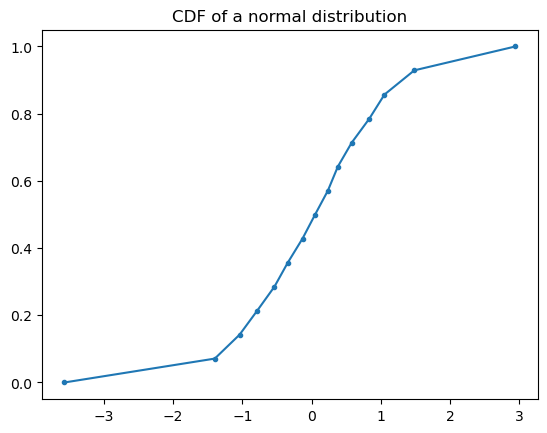

In [128]:
plt.plot(*acc.cdf, '.-')
plt.title('CDF of a normal distribution')

Text(0.5, 1.0, 'PDF (histogram) of a normal distribution')

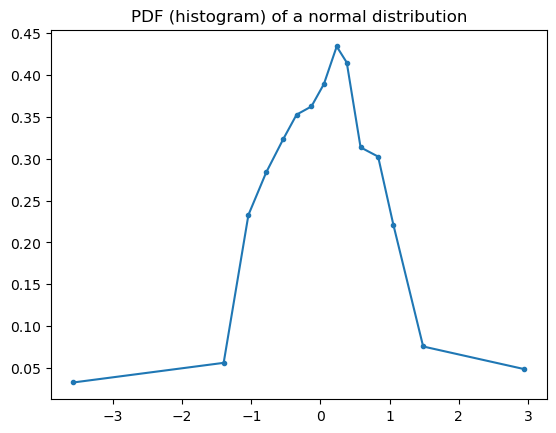

In [129]:
plt.plot(*acc.pdf, '.-')
plt.title('PDF (histogram) of a normal distribution')

In [130]:
# Estimate the mean as the 0.5 quantile.
acc.quantile_interp(0.5)

0.05142329003311511

# Median Estimator

The Median estimater is a CDF Estimator always returninng a estimate for the current Median. Lets see how that converges compared to the `np.median` function

In [147]:
data = np.random.normal(size=1000)
acc = gp.accumulators.MedianEstimator()

npmedians = [np.median(data[:i]) for i in range(1, 1000)]
accmedians = []
for d in data:
    acc += d
    accmedians.append(acc.value)

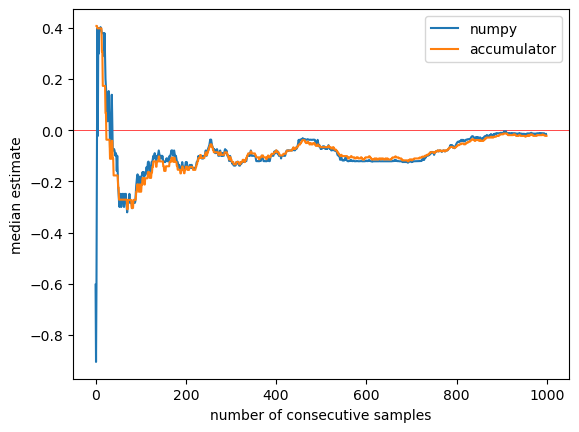

In [148]:
plt.axhline(0, lw=0.5, c='r')
plt.plot(npmedians, label='numpy')
plt.plot(accmedians, label='accumulator')
plt.xlabel('number of consecutive samples')
plt.ylabel('median estimate')
plt.legend()